# 1- Business Understanding

The aim of this notebook is to create a model that will be able to find out which users might buy a product after seeing a promotion, have a targeted marketing campain, and thus, make more profits.

We should understand the features V1 through V7 without knowing what does each feature induce.

We will explore 2 approaches with different sampling techniques:
1. Logistic Regression 
2. Uplift modeling

The data exploited is provided by Starbucks from one of their take-home assignment for their job candidates.

## Assumptions

- Although a single individual could be represented by multiple data points, for simplicity, we will assume that each data point represents a single individual.


## Loading the data and packages

In [1]:
# load the packages
from itertools import combinations

from driver.get_results import test_results, score
from driver.utils import promotion_strategy
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from imblearn.over_sampling import SMOTE
import xgboost as xgb


import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

train and test data are split into 2:1 and provided by Starbucks

# 2- Data Understanding

In [2]:
# load the train data
train_data = pd.read_csv('./data/Training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [3]:
# load the test data
test_data = pd.read_csv('./data/Test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


---
Get Statistics and types of the data

In [4]:
train_data.shape
#test_data.shape

(84534, 10)

In [5]:
train_data.describe()
# test_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [6]:
train_data.dtypes
# test_data.dtypes

ID             int64
Promotion     object
purchase       int64
V1             int64
V2           float64
V3           float64
V4             int64
V5             int64
V6             int64
V7             int64
dtype: object

---
Check for missing values

In [7]:
train_data.isnull().sum()
# test_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

Checking the promotion values

In [8]:
train_promotion = train_data['Promotion'].value_counts()
train_promotion_rate = train_promotion/train_data.shape[0]
train_promotion, train_promotion_rate

(Yes    42364
 No     42170
 Name: Promotion, dtype: int64,
 Yes    0.501147
 No     0.498853
 Name: Promotion, dtype: float64)

Checking the purchase values

In [9]:
train_purchase = train_data['purchase'].value_counts()
train_purchase_rate = train_purchase/train_data.shape[0]
train_purchase, train_purchase_rate, train_purchase[0]/train_purchase[1]

(0    83494
 1     1040
 Name: purchase, dtype: int64,
 0    0.987697
 1    0.012303
 Name: purchase, dtype: float64,
 80.2826923076923)

**It is important to note that there is a huge imbalance between the number of data points that did not purchase vs number of data points that did purchase (80.3 times)**

If we do not account/handle these imbalances the model is most likely to predict all the data points to make no purchase.

---
### Exploring the features V1 --> V7

In [10]:
# put the features in a list to draw their plots
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

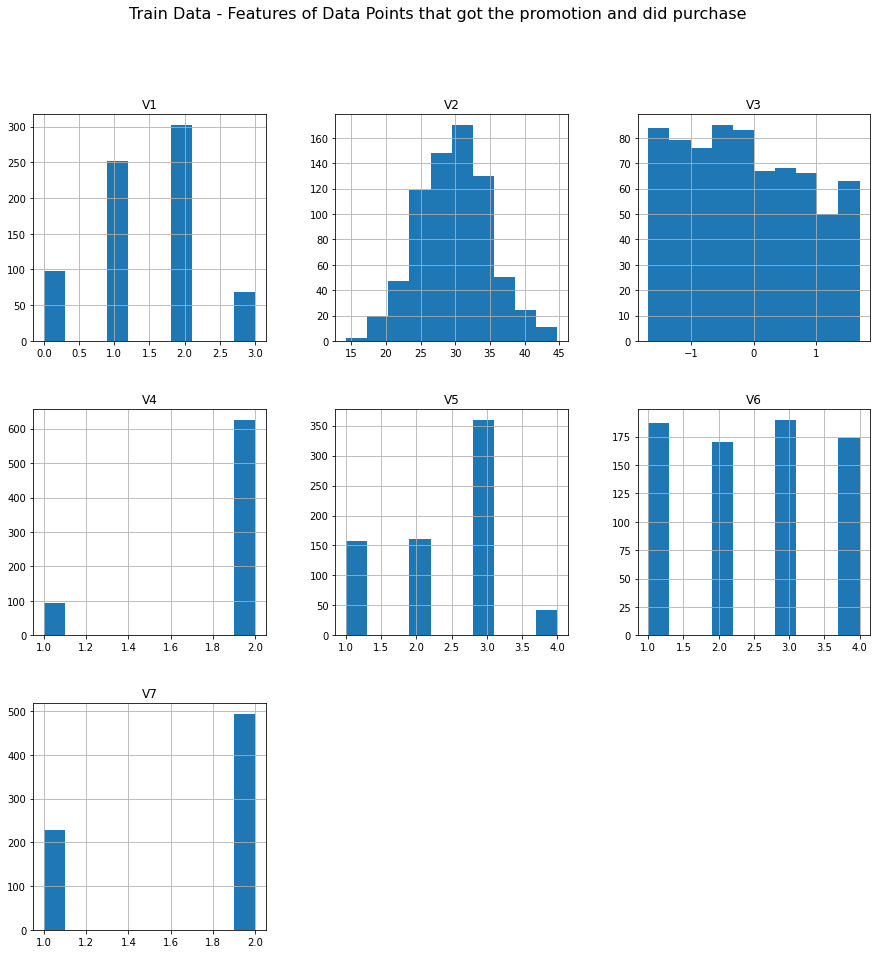

In [11]:
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==1)][features].hist(figsize=(15,15))
plt.suptitle('Train Data - Features of Data Points that got the promotion and did purchase', fontsize=16);

# test_data[(test_data['Promotion']=='Yes') & (test_data['purchase']==1)][features].hist(figsize=(15,15))
# plt.suptitle('Test Data - Features of Data Points that got the promotion and did purchase', fontsize=16);

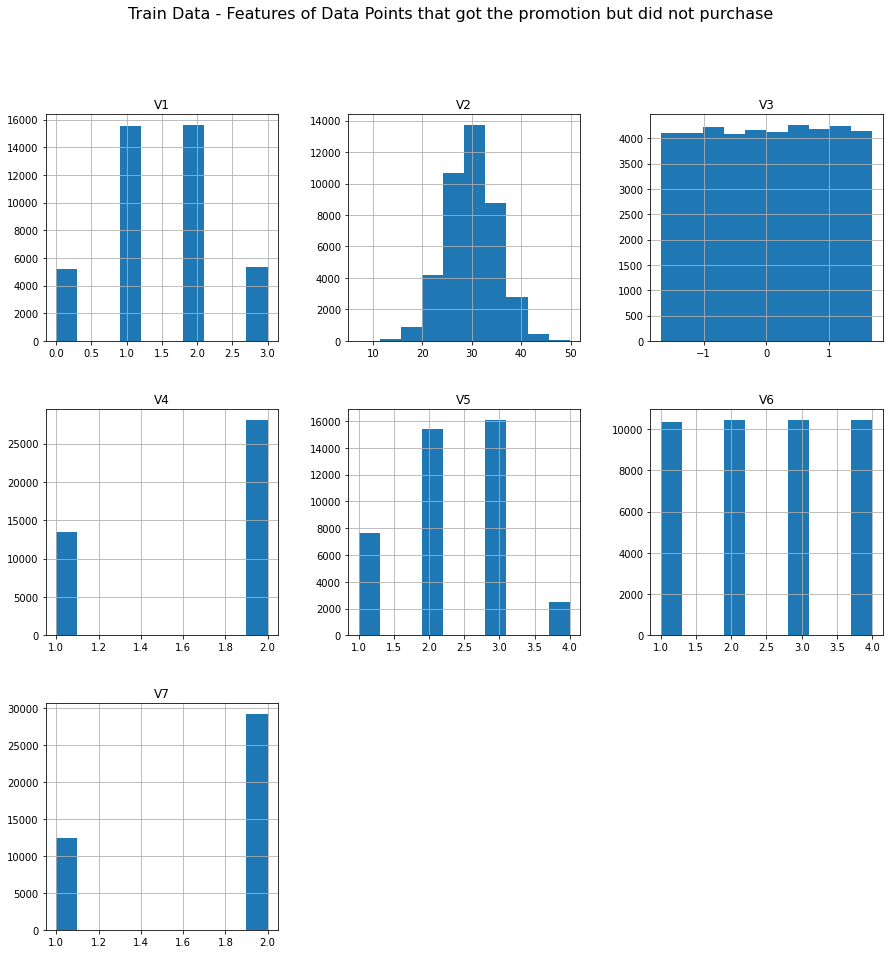

In [12]:
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==0)][features].hist(figsize=(15,15))
plt.suptitle('Train Data - Features of Data Points that got the promotion but did not purchase', fontsize=16);

# test_data[(test_data['Promotion']=='Yes') & (test_data['purchase']==0)][features].hist(figsize=(15,15))
# plt.suptitle('Test Data - Features of Data Points that got the promotion but did not purchase', fontsize=16);

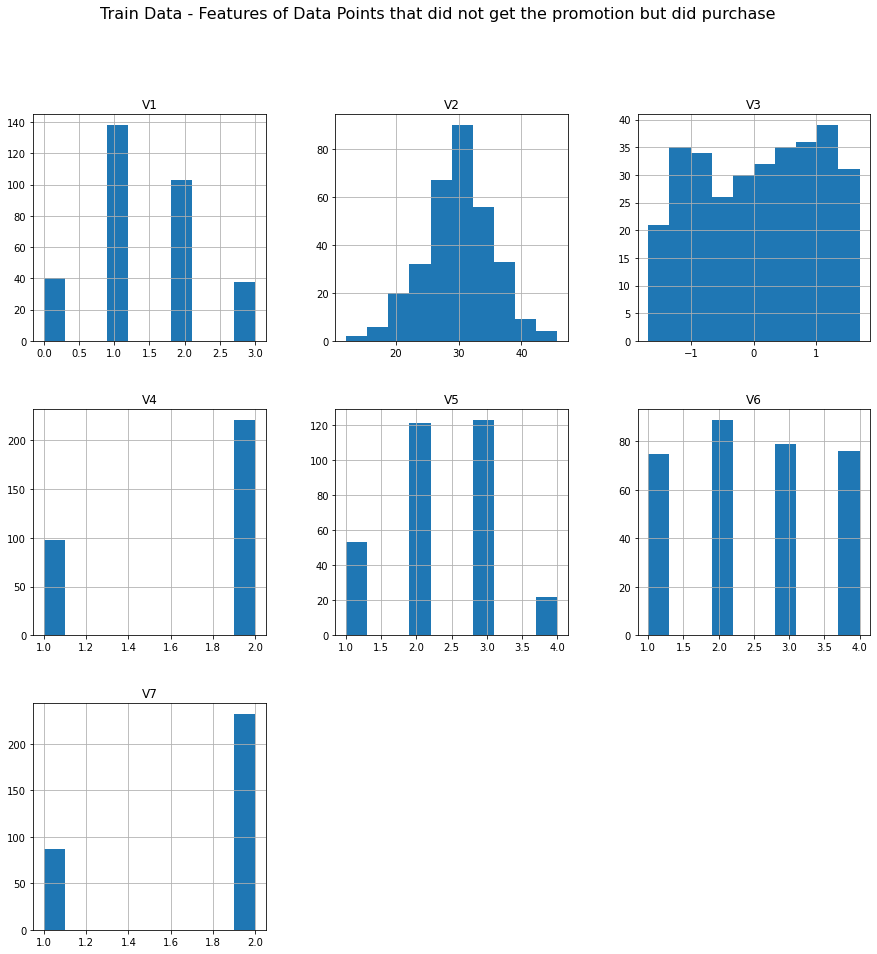

In [13]:
train_data[(train_data['Promotion']=='No') & (train_data['purchase']==1)][features].hist(figsize=(15,15))
plt.suptitle('Train Data - Features of Data Points that did not get the promotion but did purchase', fontsize=16);

# test_data[(test_data['Promotion']=='No') & (test_data['purchase']==1)][features].hist(figsize=(15,15))
# plt.suptitle('Test Data - Features of Data Points that did not get the promotion but did purchase', fontsize=16);

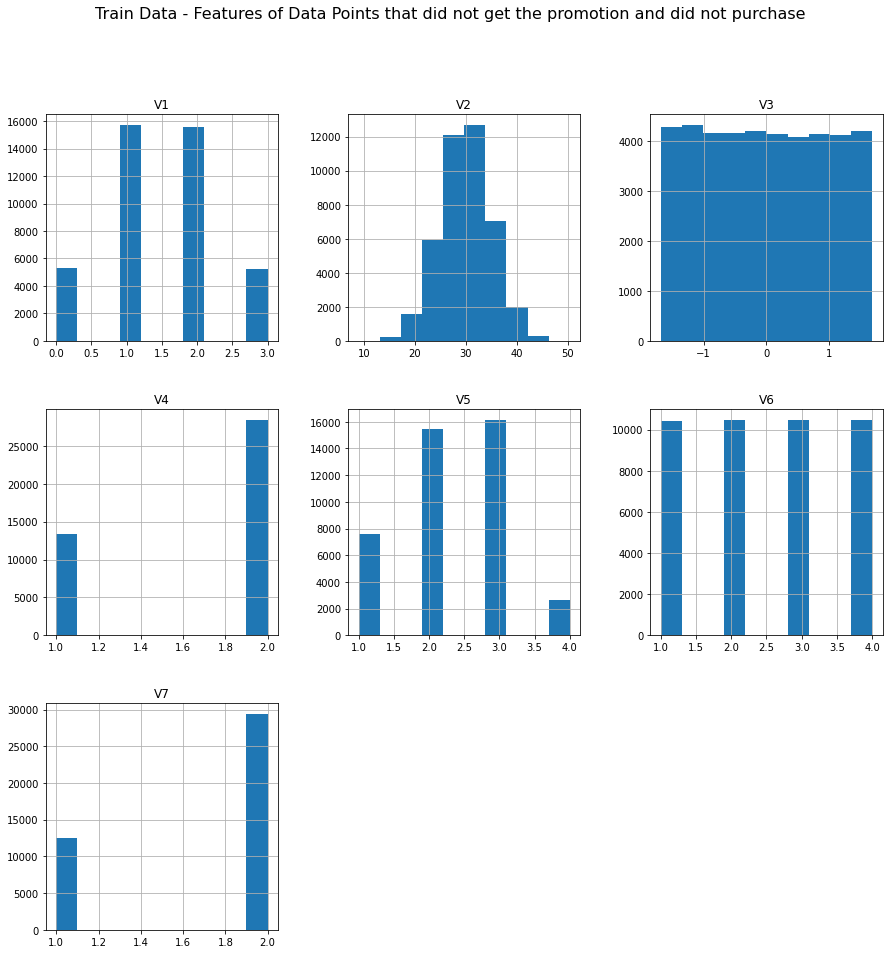

In [14]:
train_data[(train_data['Promotion']=='No') & (train_data['purchase']==0)][features].hist(figsize=(15,15))
plt.suptitle('Train Data - Features of Data Points that did not get the promotion and did not purchase', fontsize=16);

# test_data[(test_data['Promotion']=='No') & (test_data['purchase']==0)][features].hist(figsize=(15,15))
# plt.suptitle('Test Data - Features of Data Points that did not get the promotion and did not purchase', fontsize=16);

### What if we were to send the promotion to everyone?

In [15]:
test_results(promotion_strategy, 'all_purchase')

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.009593158278250108, -1132.1999999999998)

By sending everyone a promotion, the IRR = 0.96% and NIR = -1132.2$ 

The above numbers clearly show that an optimization strategy is needed to win the company money instead of losing in this promotion campain and get better IRR results.

# 3- Data Preparation

In [16]:
train_no_purch = train_data.loc[train_data['purchase'] == 0]
train_no_purch.shape

(83494, 10)

In [17]:
train_purch = train_data.loc[train_data['purchase'] == 1]
train_purch.shape

(1040, 10)

In [18]:
# Randomly sample 1040 rows from not purchased dataset
train_no_purch_sampled = train_no_purch.sample(n=1040)

train_no_purch_sampled.shape

(1040, 10)

In [19]:
# new training dataset with half purchased and half not purchased
df_train = pd.concat([train_no_purch_sampled, train_purch], axis=0)
df_train.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
55690,83009,Yes,0,1,25.757635,-1.511395,2,3,4,2
12884,19204,No,0,1,27.566136,-0.299306,2,1,2,2
18906,28122,Yes,0,0,33.759277,-0.732194,2,3,3,2
5804,8636,Yes,0,1,24.865352,1.605406,2,2,2,1
62328,92866,No,0,2,24.245916,1.691984,2,3,4,2


---
**we can see from the above charts that columns V1, V4, V5, V6, and V7 include categorical variables**
Since the splitting the variables will not conclude to a huge amount of column addition, we do not have a scaling problem here and can split each category into a separate column.

In [20]:
# split categorical variables into dummy columns
df_train = pd.get_dummies(data=df_train, columns=['V1','V4', 'V5','V6','V7'])

In [21]:
df_train.head()

,ID,Promotion,purchase,V2,V3,V1_0,V1_1,V1_2,V1_3,V4_1,...,V5_1,V5_2,V5_3,V5_4,V6_1,V6_2,V6_3,V6_4,V7_1,V7_2
55690,83009,Yes,0,25.757635,-1.511395,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,1
12884,19204,No,0,27.566136,-0.299306,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,1
18906,28122,Yes,0,33.759277,-0.732194,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
5804,8636,Yes,0,24.865352,1.605406,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
62328,92866,No,0,24.245916,1.691984,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1


In [22]:
# create training and testing vars
x = df_train.loc[:,'V2':] 
y = df_train['purchase']
X_train, X_valid, Y_train, Y_valid = train_test_split(x, y, test_size=0.3, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)


(1456, 18) (1456,)
(624, 18) (624,)


# 4- Modeling
# Approach 1 - Logistic Regression

In [23]:
# logistic regression modeling on new training data df_train
logistic_model = LogisticRegression()
logistic_model.fit(X_train, Y_train)
preds = logistic_model.predict(X_valid)
confusion_matrix(Y_valid, preds)

array([[161, 157],
       [102, 204]])

In [24]:
# precision_score(y_valid, preds)
# accuracy_score(y_valid, preds)
recall_score(Y_valid, preds)

0.6666666666666666

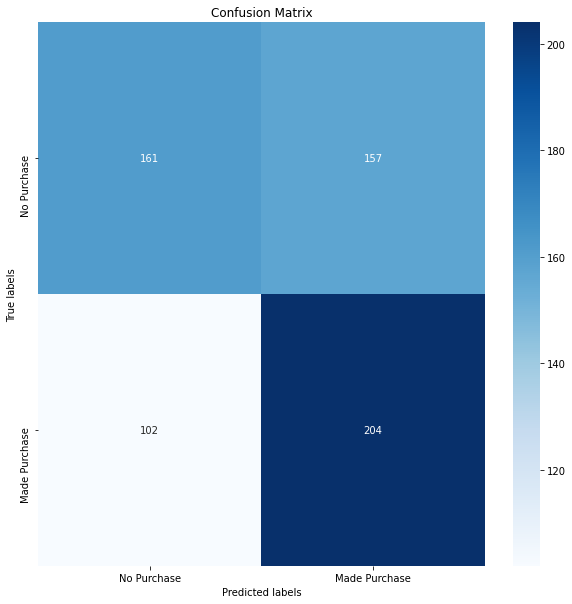

In [25]:
fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(confusion_matrix(Y_valid, preds), annot=True, fmt='g', cmap='Blues', ax = ax); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [26]:
#transform 0/1 array to Yes/No array
my_map = {0: "No", 1: "Yes"}
promotion = np.vectorize(my_map.get)(preds)
promotion

array(['No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No',
       'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes',
       'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No',
       'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No',
       'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No',
       'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes',
       'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes',
       'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No',
       'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes',
       'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No',
       'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No',
       'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes',
       'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes',
       'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'N

In [27]:
test_results(promotion_strategy,'logistic_regression', model=logistic_model)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0192.

Your nir with this strategy is 420.70.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.019209410858773406, 420.70000000000005)

# Approach 2 - Uplift Modeling - XGBoost

We will train a predictive model on only the treatment group, in other words the data points that received the promotion. 

We will split the data into the data points that purchased or did not purchase, then use the SMOTE technique to upsample the minority (purchase) data only on the training set. (which will guarantee equivalent data points for each class) 

In [28]:
# Data points that made a purchase after receiving a promotion will be assigned a label of 1, 
# The other Data points will be given a label of 0
response = []
for index, row in train_data.iterrows():
    if (row['purchase'] == 1) and (row['Promotion']=='Yes'):
        response.append(1.0)
    else:
        response.append(0.0)
        
train_data['response'] = response

In [29]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

In [30]:
# generate features and labels
Y_train = train['response']
X_train = train[features] # features is a list containing the features from V1 up to V7

Y_valid = valid['response']
X_valid = valid[features]

In [31]:
# up sample only the train dataset with SMOTE
sm = SMOTE(random_state=42, sampling_strategy = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_resample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)
Y_train_upsamp = pd.Series(Y_train_upsamp)

In [32]:
# Train the xgboost model
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
uplift_model = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7, min_child_weight = 5, objective = 'binary:logistic', seed = 42, gamma = 0.1, silent = True)
uplift_model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set, eval_metric="auc", verbose=True, early_stopping_rounds=30)

[21:30:00] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.74629	validation_1-auc:0.56087
[1]	validation_0-auc:0.77346	validation_1-auc:0.56746
[2]	validation_0-auc:0.77602	validation_1-auc:0.56480
[3]	validation_0-auc:0.77910	validation_1-auc:0.56450
[4]	validation_0-auc:0.79753	validation_1-auc:0.55870
[5]	validation_0-auc:0.79829	validation_1-auc:0.56814
[6]	validation_0-auc:0.81814	validation_1-auc:0.57547
[7]	validation_0-auc:0.81955	validation_1-auc:0.57279
[8]	validation_0-auc:0.82778	validation_1-auc:0.57008
[9]	validation_0-auc:0.83510	validation_1-auc:0.57113
[10]	validation_0-auc:0.83852	validation_1-auc:0.57553
[11]	validation_0-auc:0.84447	validation_1-auc:0.57453
[12]	validation_0-auc:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

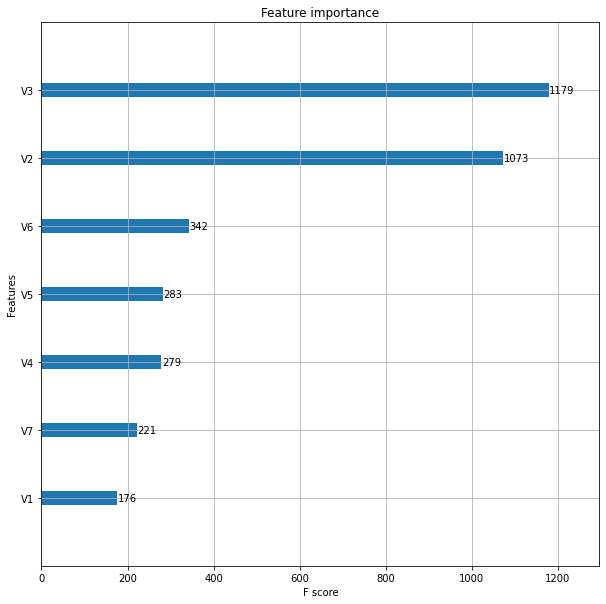

In [33]:
# check which features are important
from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 10));
xgb.plot_importance(uplift_model, ax=ax);

In [34]:
# confusion matrix for the validation set
valid_pred = uplift_model.predict(X_valid, ntree_limit=uplift_model.best_ntree_limit)
cm = sk.metrics.confusion_matrix
cm(Y_valid, valid_pred)

array([[12769,  3997],
       [   96,    45]])

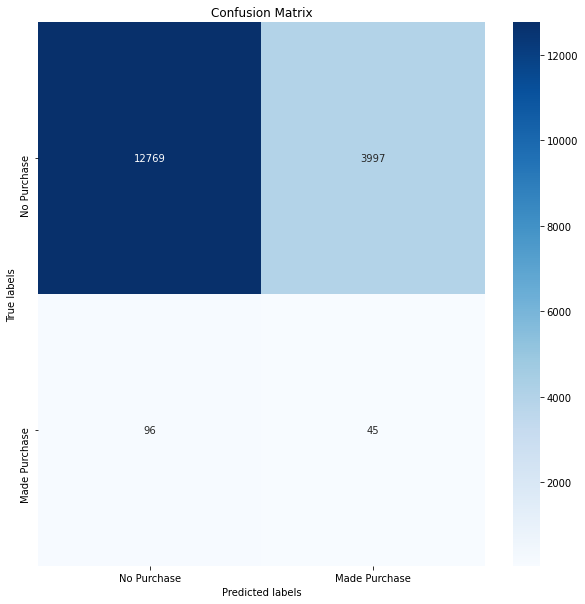

In [35]:
# plot the confusion matrix

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm(Y_valid, valid_pred), annot=True, fmt='g', ax = ax, cmap="Blues"); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [36]:
# This will test your results, and provide you back some information on how well your promotion_strategy will work in practice

test_results(promotion_strategy, tpe='uplift', model=uplift_model)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0188.

Your nir with this strategy is 181.90.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01880489698332953, 181.89999999999998)

---
# Conclusion

Using the Logistic Regression (LR) approach, we were able to reach more than starbucks' expected net incremental revenue (\\$420.7) while we got almost the same nir (\\$182) using the Uplift modeling. Moreover, both Incremental Response Rates were close (1.92% and 1.88% respectively). The LR model outperformed the Uplift model regarding both indices (NIR and IIR). 

While we have a big imbalance in the purchased data that needed to be handled, the results showed a clear benefit for starbucks' in using the targeted promotion after the usage of any of these 2 models. Even though more experiments and sampling could be performed in order to induce better predictions, the results were satisfactory compared to Starbucks' goals.

